In [1]:
%matplotlib inline
import numpy as np
#from autograd import numpy as np
import bayesian_pdes as bpdes
from scipy import stats
import matplotlib.pyplot as plt
import mcmc
import sympy as sp
import os
import hydrocyclone
%load_ext mcmc
%mcmc notebook

In [2]:
use_dummy_data = False
dummy_data_file = os.path.join('dummy_data', 'centered_blob')

In [3]:
scale = 1000
stim_current = 1.0

kernel_variance_mult = 1e-2
kernel_ls = 0.3
conductivity_variance_mult = 1. # 1e-3 is good
conductivity_ls = 0.3
run_time = 11

likelihood_variance = 1e-6 # variance for the observation model - based on the value from RA paper

In [4]:
baseline = np.loadtxt('recovered_rhos.csv', delimiter=',')
baseline_xy = baseline[:,:2]
baseline_fields = baseline[:,2:]

# Sheet Parameters

In [5]:
# important helpers!
def plot_circle(x, y, values, cmap=None):
    plt.tripcolor(x.ravel(), y.ravel(), values.ravel(), cmap=cmap)
    plt.colorbar()
    plt.legend()
    plt.axis('scaled')
    plt.xlim(-1.1,1.1); plt.ylim(-1.1,1.1);

In [6]:
# code for setting up the stim pattern
stim_pattern = np.zeros((7,8))
for i in xrange(7):
    stim_pattern[i,0] = 1
    stim_pattern[i, i+1] = -1
stim_pattern = stim_pattern*stim_current

In [7]:
meas_pattern = np.zeros((7,8))
meas_pattern[:,0] = 1
meas_pattern[:, 1:] = np.diag(-np.ones(7))

In [8]:
pattern = hydrocyclone.grids.EITPattern(meas_pattern, stim_pattern)

# Load Data

In [9]:
data_file = '../data/ST1trial3.DAT'
raw_data = np.loadtxt(data_file)

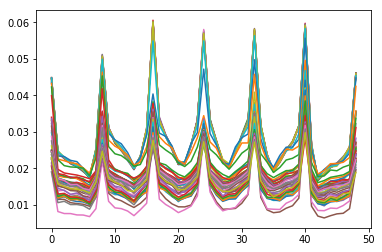

In [10]:
plt.plot(raw_data[:,1:].T);

In [11]:
raw_data.shape

(49, 50)

The data file format is as follows:
* Each row corresponds to a time
* The first element of the row gives the time index of the measurement
* The remaining columns give the measurements for each time
* These are divided into seven blocks.
    - Call the block $i$
    - Within the block the measurements correspond to electrodes $j=1,\dots,8$, $j\neq i$
    - Pair $(i,j)$ represents passing a current between electrode $i$ and electrode $j$ and measuring the voltage.
    - The voltage is measured between the _reference_ electrode at $1$ and the electrode located at $1+i$

_Is there not one too many electrodes here? This implies at some point we measure the voltage between 1 and 2 based on a current driven between 1 and 2._

_Is there a linear independence problem here? I still think there might be._

In [12]:
def data_to_dict(data):
    res = {}
    for r in data:
        time = r[0]
        other_data = r[1:]
        res[time] = scale*other_data.reshape((7,7))
    return res

In [13]:
data_dict = data_to_dict(raw_data)
# quick check to make sure the data dict matches expectation
assert np.all(data_dict[1][0] == scale*raw_data[0][1:8])

In [14]:
dummy_data = np.load(os.path.join(dummy_data_file, 'obs.npy'))
dummy_true_field = np.load(os.path.join(dummy_data_file, 'theta.npy'))

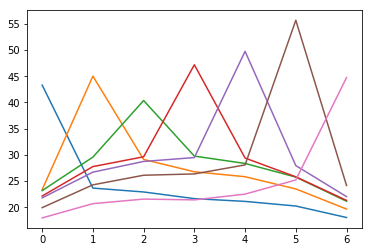

In [15]:
plt.plot(data_dict[run_time]);

# Set Up

In [16]:
from bayesian_pdes.problems import eit

In [17]:
s_x, s_xbar, s_y, s_ybar = sp.symbols('x,xbar,y,ybar')
a, a_x, a_y = sp.symbols('a,a_x,a_y')
a_bar, a_x_bar, a_y_bar = sp.symbols('abar,a_xbar,a_ybar')
s_length_scale, s_variance = sp.symbols('l,sigma')
kernel = s_variance*sp.exp(-((s_x-s_xbar)**2 + (s_y-s_ybar)**2) / (2.*s_length_scale**2))
symbols = [[s_x, s_y, a, a_x, a_y], [s_xbar, s_ybar, a_bar, a_x_bar, a_y_bar], [s_length_scale, s_variance]]

Use:
\begin{align*}
    \nabla \cdot (\exp(a)\nabla u) &= \nabla \exp(a) \cdot \nabla u + \exp(a) \nabla^2 u \\
    &= \exp(a) \left( \nabla a \cdot \nabla u + \nabla^2 u \right) \\
    &= \exp(a) \left( a_x u_x + a_y u_y + u_{xx} + u_{yy} \right)
\end{align*}
and:
\begin{align*}
    \exp(a) \nabla u \cdot n &= \exp(a) (x u_x + y u_y)
\end{align*}
for the special case of a unit circular domain centered at the origin.

In [18]:
def A(k):
    return sp.exp(a)*(k.diff(s_x,s_x) + k.diff(s_y,s_y) + k.diff(s_x)*a_x + k.diff(s_y)*a_y)
def A_bar(k):
    return sp.exp(a_bar)*(k.diff(s_xbar,s_xbar) + k.diff(s_ybar,s_ybar) + k.diff(s_xbar)*a_x_bar + k.diff(s_ybar)*a_y_bar)
def B(k):
    return sp.exp(a)*(k.diff(s_x)*s_x + k.diff(s_y)*s_y)
def B_bar(k):
    return sp.exp(a_bar)*(k.diff(s_xbar)*s_xbar + k.diff(s_ybar)*s_ybar)

In [19]:
op_system = bpdes.operator_compilation.sympy_gram.compile_sympy(
    [A, B], [A_bar, B_bar],
    kernel,
    symbols,
    parallel=True
)

In [20]:
#op_system_factory = eit.EITFactory(kernel, symbols[0], symbols[1], symbols[2])

## Define the collocation grid

In [21]:
n_in_shell = 8
n_bdy = 64
n_sensor = 8
grid = hydrocyclone.grids.construct_circular(n_in_shell, n_bdy, n_sensor)

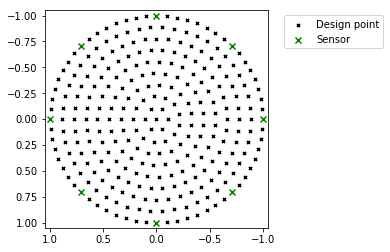

In [22]:
# plot design points
plt.figure(figsize=(4,4))
plt.scatter(grid.interior[:,0], grid.interior[:,1], marker='x', color='black', s=10)
plt.scatter(grid.boundary[:,0], grid.boundary[:,1], marker='x', color='black', s=10, label='Design point')
plt.scatter(grid.sensors[:,0], grid.sensors[:,1], marker='x', color='green', label='Sensor')
plt.xlim(1.05,-1.05);plt.ylim(1.05,-1.05)
plt.legend(loc=2, bbox_to_anchor=(1.05,1))

## Set up Proposal Matrix

In [23]:
proposal_kernel = kernel
def diff_x(k):
    return k.diff(s_x)
def diff_y(k):
    return k.diff(s_y)
def diff_x_bar(k):
    return k.diff(s_xbar)
def diff_y_bar(k):
    return k.diff(s_ybar)

proposal_op_system = bpdes.operator_compilation.sympy_gram.compile_sympy(
    [diff_x, diff_y], 
    [diff_x_bar, diff_y_bar], 
    proposal_kernel,
    [[s_x, s_y], [s_xbar, s_ybar], [s_length_scale, s_variance]]
)

In [24]:
proposal_design = hydrocyclone.grids.construct_shell(np.linspace(0,1,8))

In [25]:
full_design = np.row_stack([grid.interior_plus_boundary, grid.sensors])
proposal_fun_args = np.array([conductivity_ls, conductivity_variance_mult])
proposal_cov = bpdes.collocation.compute_operator_matrix(
    [()],
    [()],
    [proposal_design],
    [proposal_design],
    proposal_op_system,
    proposal_fun_args
)
proposal_lhs_mat = bpdes.collocation.compute_operator_matrix(
    [(), diff_x, diff_y], 
    [()],
    [full_design, grid.interior_plus_boundary, grid.interior_plus_boundary],
    [proposal_design],
    proposal_op_system,
    proposal_fun_args
)
proposal_cov_inv = np.linalg.inv(proposal_cov)
np.linalg.cond(proposal_cov)

5646662752.2742453

/Users/jon/.virtualenvs/stats/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


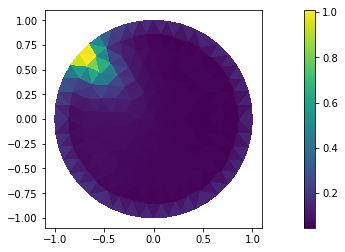

In [26]:
rhomin = 0.01
rho = baseline_fields[:,run_time-1][:,None]
rho[rho < rhomin] = rhomin
conduct = np.log(1./rho)
p = bpdes.collocate([()], [()], 
                    [(baseline_xy, conduct)],
                    proposal_op_system, 
                    np.array([0.12, 1.0]))

true_field, _ = p(proposal_design)
true_field = true_field.ravel()
plot_circle(proposal_design[:,0], proposal_design[:,1], np.exp(true_field))

In [27]:
# TO DO:
# * Swap to simulating only a lower dimensional version of the field
proposal_dot_mat = np.dot(proposal_lhs_mat, proposal_cov_inv)

# Set Up The Potential

In [28]:
# todo: choose this in a more principled way
length_scale = 0.3
fun_args = np.array([kernel_ls, kernel_variance_mult])
data = data_dict[run_time] if not use_dummy_data else dummy_data


In [29]:
# construct the proposal
proposal = mcmc.pcn.proposal(0.005, proposal_cov)
pcn_kernel = hydrocyclone.pcn_kernel.PCNKernel(proposal, grid, op_system, likelihood_variance, pattern, data, fun_args, proposal_dot_mat)

In [30]:
# choose an initial field
import scipy.optimize
def phi_const(k):
    return pcn_kernel.phi(k*np.ones(proposal_cov.shape[0]))
best_const = scipy.optimize.minimize_scalar(phi_const)
kappa_0 = best_const.x*np.ones(proposal_cov.shape[0])

In [31]:
proposals, acceptances = pcn_kernel.apply_pcn(kappa_0, 10000)

/Users/jon/Coding/mcmc/mcmc/pcn.py:95: RuntimeWarning: overflow encountered in exp
  alpha = min(1, np.exp(cur_phi-new_phi))
/Users/jon/Coding/mcmc/mcmc/storage/array_storage.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  self.__array__[self.__current_index__, :] = item


Iter 1000: Accept (38% 38%) T/Iter 0.0192s Remaining 2m53s
Iter 2000: Accept (15% 27%) T/Iter 0.0182s Remaining 2m25s
Iter 3000: Accept (2% 19%) T/Iter 0.0179s Remaining 2m5s
Iter 4000: Accept (2% 14%) T/Iter 0.0182s Remaining 1m49s
Iter 5000: Accept (2% 12%) T/Iter 0.0183s Remaining 1m31s
Iter 6000: Accept (1% 10%) T/Iter 0.0174s Remaining 1m9s
Iter 7000: Accept (0% 9%) T/Iter 0.0177s Remaining 53s
Iter 8000: Accept (0% 8%) T/Iter 0.0183s Remaining 36s
Iter 9000: Accept (0% 7%) T/Iter 0.0181s Remaining 18s
Iter 10000: Accept (0% 6%) T/Iter 0.0192s Remaining 0s


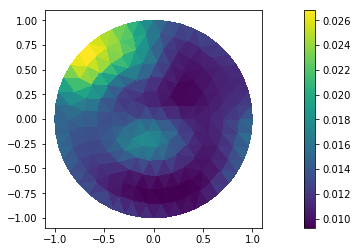

In [39]:
thin = 1
burn = int(proposals.shape[0]) / 2


recovered_field = proposals[burn::thin, :len(grid.all)].mean(axis=0)
plot_circle(proposal_design[:,0], proposal_design[:,1], np.exp(recovered_field))